In [1]:
import alibi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from alibi_detect.od import IForest
from alibi_detect.utils.perturbation import inject_outlier_tabular, inject_outlier_categorical
from alibi_detect.utils.saving import save_detector, load_detector

## Load adult dataset

The ```fetch_adult``` function returns a ```Bunch``` object containing the features, the targets, the feature names and a mapping of the categories in each categorical variable.

In [2]:
adult = alibi.datasets.fetch_adult()
X, y = adult.data, adult.target
feature_names = adult.feature_names
category_map = adult.category_map

Define shuffled train, validation (to find outlier threshold) and test set:

In [3]:
np.random.seed(0)
Xy_perm = np.random.permutation(np.c_[X, y])
X, y = Xy_perm[:,:-1], Xy_perm[:,-1]

In [4]:
n_train = 25000
n_valid = 5000
X_train, y_train = X[:n_train,:], y[:n_train]
X_valid, y_valid = X[n_train:n_train+n_valid,:], y[n_train:n_train+n_valid]
X_test, y_test = X[n_train+n_valid:,:], y[n_train+n_valid:]
print(X_train.shape, y_train.shape, 
      X_valid.shape, y_valid.shape,
      X_test.shape, y_test.shape)

(25000, 12) (25000,) (5000, 12) (5000,) (2561, 12) (2561,)


## Create outliers

Inject outliers in both the numerical and categorical features. First we need to know the features for each kind:

In [5]:
cat_cols = list(category_map.keys())
num_cols = [col for col in range(X.shape[1]) if col not in cat_cols]
print(cat_cols, num_cols)

[1, 2, 3, 4, 5, 6, 7, 11] [0, 8, 9, 10]


### Numerical

Now we can add outliers to the validation (or threshold) and test sets. For the numerical data, we need to specify the numerical columns (```cols```), the percentage of outliers (```perc_outlier```), the strength (```n_std```) and the minimum size of the perturbation (```min_std```). The outliers are distributed evenly across the numerical features:

In [6]:
perc_outlier = 10
data = inject_outlier_tabular(X_valid, num_cols, perc_outlier, n_std=3., min_std=1.)
X_threshold, y_threshold = data.data, data.target
X_threshold_, y_threshold_ = X_threshold.copy(), y_threshold.copy()  # store for comparison later
print('{:.2f}% outliers'.format(100 * y_threshold.sum() / len(y_threshold)))

9.54% outliers


Let's inspect an instance that was changed:

In [7]:
outlier_idx = np.where(y_threshold != 0)[0]
vdiff = X_threshold[outlier_idx[0]] - X_valid[outlier_idx[0]]
fdiff = np.where(vdiff != 0)[0]
print('{} changed by {:.2f}.'.format(feature_names[fdiff[0]], vdiff[fdiff[0]]))

Age changed by -15.48.


Same thing for the test set:

In [8]:
data = inject_outlier_tabular(X_test, num_cols, perc_outlier, n_std=3., min_std=1.)
X_outlier, y_outlier = data.data, data.target

### Categorical

It is much trickier to perturb categorical features towards outliers. Consider for instance the *Education* feature. It is easy to see that the category *(high school) Dropout* is very dissimilar from *Doctorate*. So if we want to create an outlier starting from an instance with *Education* equal to *Dropout*, we would like to obtain an instance where the value changes to e.g. *Prof-School* or *Doctorate*. Other features however don't have a natural order like *Country* or *Relationship*. 

In order to obtain a meaningful perturbation, we first compute the pairwise distances between categories of a categorical variable based on the context provided by the other variables in the dataset. This method is based on the *Association-Based Distance Metric* (ABDM) developed by [Le et al (2005)](http://www.jaist.ac.jp/~bao/papers/N26.pdf). ABDM computes a dissimilarity measure between categories based on the Kullback-Leibler divergence. We can then apply multidimensional scaling to project the pairwise distances between all the categories into Euclidean space. This method could also help with tree-based models which assume that ordinal-encoded categorical variables are ordered. The reason behind this is that more similar (dissimilar) categories are closer (further) to (from) eachother in Euclidean space.

We need to specify the categorical columns (```cols```), the percentage of outliers (```perc_outlier```) and optionally the data we would like to fit the pairwise distances on:

In [9]:
data = inject_outlier_categorical(X_threshold, cat_cols, perc_outlier, X_fit=X)
X_threshold, y_threshold = data.data, data.target

In [10]:
data = inject_outlier_categorical(X_outlier, cat_cols, perc_outlier, X_fit=X)
X_outlier, y_outlier = data.data, data.target

We can also check whether the numerical equivalent of the categorical features makes sense:

In [11]:
def plot_bar(dist, cols, figsize=(10,4)):
    dist = dist.reshape(dist.shape[0])
    idx = np.argsort(dist)
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(cols[idx], dist[idx])
    print(cols[idx])

['Doctorate' 'Prof-School' 'Masters' 'Bachelors' 'Associates'
 'High School grad' 'Dropout']


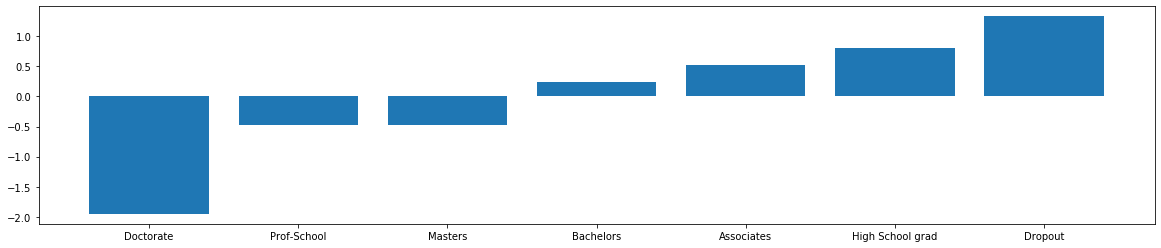

In [12]:
cat = 'Education'
idx = feature_names.index(cat)
plot_bar(data.d_abs[idx], np.array(category_map[idx]), figsize=(20,4))

The ranking for the *Education* feature looks sensible and goes from *Doctorate* to *Dropout*. We can again investigate an instance where the categorical feature has flipped:

In [16]:
i = 7

cat_idx = np.where(y_threshold != y_threshold_)[0]
vdiff = X_threshold[cat_idx[i]] - X_threshold_[cat_idx[i]]
fdiff = np.where(vdiff != 0)[0]
print('{} changed from {} to {}'.format(
    feature_names[fdiff[0]],
    category_map[fdiff[0]][X_threshold_[cat_idx[i], fdiff[0]].astype(int)],
    category_map[fdiff[0]][X_threshold[cat_idx[i], fdiff[0]].astype(int)]))

Marital Status changed from Never-Married to Married


## Define outlier detector

In [17]:
# initialize outlier detector
od = IForest(threshold=None,  # threshold for outlier score
             n_estimators=100)

# train
od.fit(X_train)

# save the trained outlier detector
filepath = './models/od_if_adult/'
save_detector(od, filepath)

/home/avl/anaconda3/envs/cdod/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning:

default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.

/home/avl/anaconda3/envs/cdod/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



* infer threshold and save updated detector

* detect outliers

* display results